# Solving the 1d Heat equation with a PINN

And now...

It's time...

For the moment you've been waiting for

1...

2...

3...

Ready?

(Please *please* make the training loop output this when training starts)

In [149]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Data

In [4]:
class TemperatureDataset(Dataset):
    def __init__(self, initial_points, initial_temps, boundary_points, random_points):
        # Random points at t = 0
        self.initial_points = initial_points
        # Temperature at each initial point
        self.initial_temps = initial_temps
        # Random points at x boundary
        self.boundary_points = boundary_points
        # Random points in domain
        self.random_points = random_points

    def __len__(self):
        return len(self.random_points)
    
    def __getitem__(self, i):
        initial_point = self.initial_points[i]
        initial_temp = self.initial_temps[i]
        boundary_point = self.boundary_points[i]
        random_point = self.random_points[i]
        return initial_point, initial_temp, boundary_point, random_point

Train and test data

In [106]:
T_RANGE = 10
X_RANGE = 1
n_train_datapoints = 100_000

# Random points at t = 0
initial_points = torch.zeros((n_train_datapoints, 2))
initial_points[:, 1] = X_RANGE * torch.rand(n_train_datapoints)
# Temperature 1 if 1/4 <= x <= 3/4, else 0
initial_temps = torch.where(((initial_points[:, 1] >= 1/4) & (initial_points[:, 1] <= 3/4)), 1.0, 0.0)

# Random points at the x boundary
boundary_points = torch.zeros((n_train_datapoints, 2))
# Pick points at random times
boundary_points[:, 0] = T_RANGE * torch.rand(n_train_datapoints)
# Pick left or right boundary points randomly
boundary_points[:, 1] = X_RANGE * (torch.rand(n_train_datapoints)[:] >= 1/2).float()

# random points in (0, T_RANGE) x (0, X_RANGE)
random_points = torch.rand((n_train_datapoints, 2))
random_points[:, 0] *= T_RANGE
random_points[:, 1] *= X_RANGE

In [107]:
for i in range(10):
    print(initial_points[i, 1], initial_temps[i])
print(boundary_points)
print(random_points)

tensor(0.4895) tensor(1.)
tensor(0.8614) tensor(0.)
tensor(0.4512) tensor(1.)
tensor(0.9533) tensor(0.)
tensor(0.3030) tensor(1.)
tensor(0.8948) tensor(0.)
tensor(0.5243) tensor(1.)
tensor(0.2859) tensor(1.)
tensor(0.2553) tensor(1.)
tensor(0.7404) tensor(1.)
tensor([[9.6391, 0.0000],
        [2.3123, 1.0000],
        [3.1069, 0.0000],
        ...,
        [9.4004, 0.0000],
        [9.0498, 0.0000],
        [0.6721, 1.0000]])
tensor([[9.2448, 0.1022],
        [0.1073, 0.4674],
        [2.8038, 0.1769],
        ...,
        [4.6200, 0.1638],
        [8.6410, 0.3219],
        [3.0561, 0.2155]])


Everything looks OK. Let's create the dataset and dataloader now.

In [108]:
batch_size = 128

In [109]:
train_dataset = TemperatureDataset(initial_points, initial_temps, boundary_points, random_points)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [110]:
for i in range(10):
    ip, it, _, _ = train_dataset[i]
    print(ip[1], it)

tensor(0.4895) tensor(1.)
tensor(0.8614) tensor(0.)
tensor(0.4512) tensor(1.)
tensor(0.9533) tensor(0.)
tensor(0.3030) tensor(1.)
tensor(0.8948) tensor(0.)
tensor(0.5243) tensor(1.)
tensor(0.2859) tensor(1.)
tensor(0.2553) tensor(1.)
tensor(0.7404) tensor(1.)


Yay it's working, now it's time to set things up and start training. First I need to figure out how to take partial derivatives.

## Model

In [190]:
class TemperatureNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # inputs = t, x
            nn.Linear(2, 512),
            nn.Tanh(),
            nn.Linear(512,512),
            nn.Tanh(),
            nn.Linear(512,512),
            nn.Tanh(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        logits = self.network(x)
        return logits

In [191]:
model = TemperatureNetwork()

This is how I'm supposed to do it in the training. Now I think I can start setting things up for training.

Model is working as expected!

## Training

In [239]:
learning_rate = 1e-4
weight_decay = 1e-4
n_epochs = 5

# This is the head conductivity or whatever
R = 1e-3

# Loss coefficients
A, B, C = 1, 1, 1

TRAIN = True

In [240]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [241]:
l1_loss = nn.SmoothL1Loss(reduction='mean')

def loss_fn(initial_temp_pred, initial_temp_target, boundary_temp_pred, dT_dt, d2T_dx2):
    global R, A, B, C
    initial_condition_loss = l1_loss(initial_temp_pred, initial_temp_target)
    boundary_condition_loss = l1_loss(boundary_temp_pred, torch.zeros_like(boundary_temp_pred))
    
    pde_difference = dT_dt - R * d2T_dx2
    pde_loss = l1_loss(pde_difference, torch.zeros_like(pde_difference))
    
    return A * initial_condition_loss + B * boundary_condition_loss + C * pde_loss

In [242]:
def train_loop(model, optimizer, loss_fn, dataloader, n_epochs):
    for epoch in range(n_epochs):
        print(f"epoch {epoch+1}-------------------")
        for i, (initial_points, initial_temps, boundary_points, random_points) in enumerate(dataloader):
            # Compute temperature at initial and boundary points
            initial_pred = model(initial_points)
            boundary_pred = model(boundary_points)

            # Compute temperature at random points
            random_points.requires_grad_(True)
            random_pred = model(random_points)

            # Compute dT/dt for each point in the batch
            dT_dt = torch.autograd.grad(random_pred, random_points, grad_outputs=torch.ones_like(random_pred), create_graph=True)[0][:, 0:1]
            
            # Compute d2T/dx2 for each point in the batch
            dT_dx = torch.autograd.grad(random_pred, random_points, grad_outputs=torch.ones_like(random_pred), create_graph=True)[0][:, 1:2]
            d2T_dx2 = torch.autograd.grad(dT_dx, random_points, grad_outputs=torch.ones_like(dT_dx), create_graph=True)[0][:, 1:2]

            # Compute loss and optimize
            loss = loss_fn(initial_pred, initial_temps.unsqueeze(dim=1), boundary_pred, dT_dt, d2T_dx2)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i % 100 == 0:
                with torch.no_grad():
                    print(f"train loss at batch {i}: {loss}")

In [243]:
if TRAIN:
    train_loop(model, optimizer, loss_fn, train_dataloader, n_epochs)

epoch 1-------------------
train loss at batch 0: 0.004692824091762304
train loss at batch 100: 0.0017684544436633587
train loss at batch 200: 0.0016036920715123415
train loss at batch 300: 0.0004459763295017183
train loss at batch 400: 0.0017440504161641002
train loss at batch 500: 0.0018311261665076017
train loss at batch 600: 0.0032216659747064114
train loss at batch 700: 0.001162561820819974
epoch 2-------------------
train loss at batch 0: 0.0025850834790617228
train loss at batch 100: 0.00022195051133166999
train loss at batch 200: 0.0007529602153226733
train loss at batch 300: 0.002447469625622034
train loss at batch 400: 0.0009194119484163821
train loss at batch 500: 0.0010070869466289878
train loss at batch 600: 0.0025525973178446293
train loss at batch 700: 0.0029244052711874247
epoch 3-------------------
train loss at batch 0: 0.0028871679678559303
train loss at batch 100: 0.002380386460572481
train loss at batch 200: 0.0012182247592136264
train loss at batch 300: 0.00131402

In [244]:
def display_model_output_with_animation(model, t_range=(0, T_RANGE), x_range=(0, X_RANGE), resolution=(100, 100)):
    model.eval()  # Set the model to evaluation mode
    
    # Create a grid of time and position values
    t = np.linspace(t_range[0], t_range[1], resolution[0])
    x = np.linspace(x_range[0], x_range[1], resolution[1])
    T, X = np.meshgrid(t, x)
    
    # Prepare input for the model
    points = np.vstack((T.flatten(), X.flatten())).T
    points_tensor = torch.FloatTensor(points)
    
    # Generate predictions
    with torch.no_grad():
        temp_pred = model(points_tensor).cpu().numpy()
    
    # Reshape the output for plotting
    temp_pred = temp_pred.reshape(resolution[1], resolution[0])
    
    # Create the static plot
    plt.figure(figsize=(12, 6))
    plt.imshow(temp_pred, extent=[t_range[0], t_range[1], x_range[0], x_range[1]], 
               aspect='auto', cmap='hot', origin='lower')
    plt.colorbar(label='Temperature')
    plt.title('Temperature Distribution over Time and Position')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.show()

    # Create the animation
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot(x, temp_pred[:, 0])
    ax.set_ylim(temp_pred.min(), temp_pred.max())
    ax.set_xlim(x_range)
    ax.set_title('Temperature Distribution Over Position')
    ax.set_xlabel('Position')
    ax.set_ylabel('Temperature')

    def update(frame):
        line.set_ydata(temp_pred[:, frame])
        ax.set_title(f'Temperature Distribution at Time = {t[frame]:.2f}')
        return line,

    anim = FuncAnimation(fig, update, frames=resolution[0], interval=50, blit=True)
    
    # Close the figure to prevent it from being displayed
    plt.close(fig)
    
    return HTML(anim.to_jshtml())

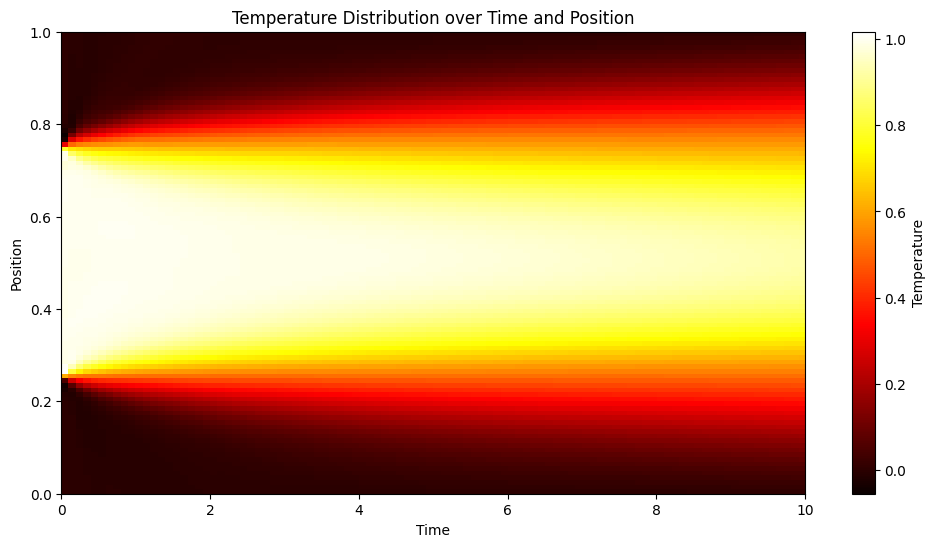

In [245]:
animation = display_model_output_with_animation(model)
display(animation)